In [2]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import uproot
from autogluon.tabular import TabularPredictor
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from getS50 import getS50

# import multiprocessing

from scipy.stats import poisson
from scipy.optimize import minimize

# from optimparallel import minimize_parallel
from tqdm.notebook import tqdm


In [7]:
5e-13*80**-2.11*719.15 * time_rate * 24 * 60 * 60*30000 * 30000 * 3.1415926*40

106.06155797214596

In [3]:
def corrdinateToYBJ(Ra, Dec, mjd):
    """Transform J2000 to YBJ ALTAZ

    Args:
        Ra (np.array): Ra in J2000
        Dec (np.array): Dec in J2000
        mjd (np.array): mjd
    Returns:
        np.array: List of fo8ur np.array, first is theta with degree, second is phi with degree
    """
    YBJ_Location = EarthLocation(
        lat=30.102 * u.deg, lon=90.522 * u.deg, height=4300 * u.m
    )
    mjdtime = Time(mjd, format="mjd", location=YBJ_Location)
    newAltAzcoordiantes = SkyCoord(
        ra=Ra * u.deg,
        dec=Dec * u.deg,
        obstime=mjdtime,
        frame="icrs",
        location=YBJ_Location,
    )
    # LST = mjdtime.sidereal_time("apparent").degree
    alt = newAltAzcoordiantes.altaz.alt.degree
    az = newAltAzcoordiantes.altaz.az.degree
    return [
        90 - alt,
        az,
    ]


In [4]:
number = 100000
mjd = np.linspace(56710, 56715, number)
theta, phi = corrdinateToYBJ(0, 2.5, mjd)
time_rate = np.sum(theta < 60) / number


In [6]:
time_rate

0.31284

In [4]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)


In [5]:
MCdata = uproot.open("/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/RESULT.root")


In [6]:
paraneed = [
    "nch",
    "inout",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "pritheta",
    "priphi",
    "prie",
]


In [7]:
MCdata = MCdata["asresult"].arrays(paraneed, library="np")
MCdata["S50"] = getS50(MCdata["ne"], MCdata["age"])
MCdatacuted = np.where(
    (MCdata["inout"] == 1)
    & (MCdata["sigma"] < 1)
    & (MCdata["nch"] >= 16)
    & (MCdata["theta"] < 60)
    & (MCdata["S50"] > 10**-1.2)
    & (MCdata["age"] > 0.31)
    & (MCdata["age"] < 1.3)
    & (MCdata["sumpf"] > 100)
    & ((MCdata["summd"] < 0.4) | (MCdata["summd"] < 1.2e-3 * MCdata["sumpf"] ** 1.6))
)

MCdata = {key: MCdata[key][MCdatacuted] for key in MCdata.keys()}
MCdata["pritheta"] = np.rad2deg(MCdata["pritheta"])
MCdata["priphi"] = np.rad2deg(MCdata["priphi"])
MCdata["priphi"] = 180 - MCdata["priphi"]
MCdata["priphi"][MCdata["priphi"] > 180] = (
    MCdata["priphi"][MCdata["priphi"] > 180] - 360
)
MCdata["prie"] = MCdata["prie"] / 1000


In [8]:
predictor = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR_Allsky_MC_5par_random_2"
)
predictor_energy = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy"
)
predictor_deltatheta = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/deltatheta"
)
predictor_deltaphi = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/deltaphi"
)


In [9]:
MCdata_df = pd.DataFrame(MCdata)
MCdata["isgamma"] = np.zeros_like(MCdata["summd"])
MCdata["energy"] = np.zeros_like(MCdata["summd"])
MCdata["isgamma"] = predictor.predict_proba(MCdata_df)[1].to_numpy()
MCdata_df["sumpf"] = np.log10(MCdata_df["sumpf"])
MCdata["energy"] = 10 ** predictor_energy.predict(MCdata_df).to_numpy()
MCdata["newtheta"] = (
    MCdata["theta"] - predictor_deltatheta.predict(MCdata_df).to_numpy()
)
MCdata["newphi"] = MCdata["phi"] - predictor_deltaphi.predict(MCdata_df).to_numpy()


In [10]:
need = np.where(MCdata["isgamma"] > 0.8)
MCdata = {key: MCdata[key][need] for key in MCdata}


In [11]:
Energybin = np.load(
    "/home2/hky/github/Gamma_Energy/find_source/data/isgammacut_0.8/Energybin.npy"
)
priEnergybin = np.logspace(0.6, 4, 18)
PSF = np.zeros([len(Energybin) - 1, NPIX])


In [12]:
R_z = np.zeros([len(MCdata["pritheta"]), 3, 3])
R_y = np.zeros([len(MCdata["pritheta"]), 3, 3])

R_z[:, 2, 2] = 1
R_z[:, 0, 0] = np.cos(np.deg2rad(MCdata["priphi"]))
R_z[:, 0, 1] = np.sin(np.deg2rad(MCdata["priphi"]))
R_z[:, 1, 0] = -np.sin(np.deg2rad(MCdata["priphi"]))
R_z[:, 1, 1] = np.cos(np.deg2rad(MCdata["priphi"]))

R_y[:, 1, 1] = 1
R_y[:, 0, 0] = np.cos(np.deg2rad(MCdata["pritheta"]))
R_y[:, 0, 2] = -np.sin(np.deg2rad(MCdata["pritheta"]))
R_y[:, 2, 0] = np.sin(np.deg2rad(MCdata["pritheta"]))
R_y[:, 2, 2] = np.cos(np.deg2rad(MCdata["pritheta"]))


In [13]:
angvec = hp.ang2vec(np.deg2rad(MCdata["newtheta"]), np.deg2rad(MCdata["newphi"]))
for i in range(len(MCdata["pritheta"])):
    angvec[i] = np.matmul(R_z[i], angvec[i].T)
    angvec[i] = np.matmul(R_y[i], angvec[i].T)
    for j in range(len(Energybin) - 1):
        if (
            MCdata["energy"][i] > Energybin[j]
            and MCdata["energy"][i] < Energybin[j + 1]
        ):
            PSF[j, hp.vec2pix(NSIDE, *angvec[i])] += 1
            break


In [14]:
PSFl = list()
for i in range(PSF.shape[0]):
    PSFl.append(hp.map2alm(PSF[i] / np.sum(PSF[i]), mmax=0))
PSFl = np.array(PSFl)
PSFl = PSFl[3:-10, :]


/tmp/ipykernel_390425/1561911625.py:3: RuntimeWarning: invalid value encountered in divide
  PSFl.append(hp.map2alm(PSF[i] / np.sum(PSF[i]), mmax=0))


Text(0.5, 1.0, 'PSF')

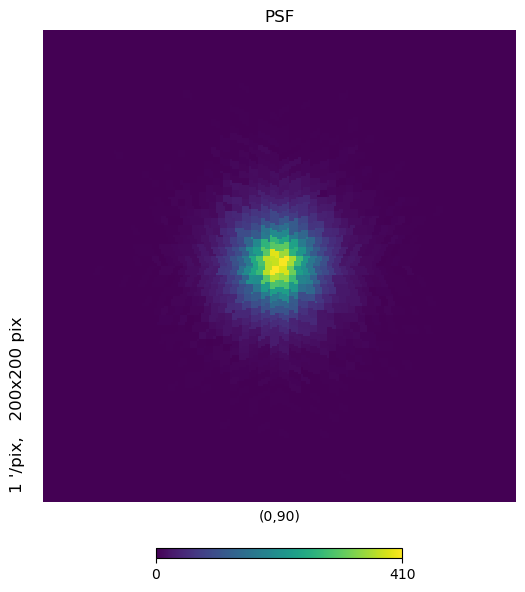

In [15]:
hp.gnomview(np.sum(PSF, axis=0), rot=[0, 90], xsize=200, reso=1)
plt.title("PSF")


In [16]:
Energybin = Energybin[3:-10]


In [17]:
PSF2 = np.zeros_like(PSF)
for i in range(PSF.shape[0]):
    PSF2[i] = hp.alm2map(hp.map2alm(PSF[i], mmax=0), NSIDE, lmax=3 * NSIDE - 1, mmax=0)
PSF2[np.isnan(PSF2)] = 0


Text(0.5, 1.0, 'PSF_SH')

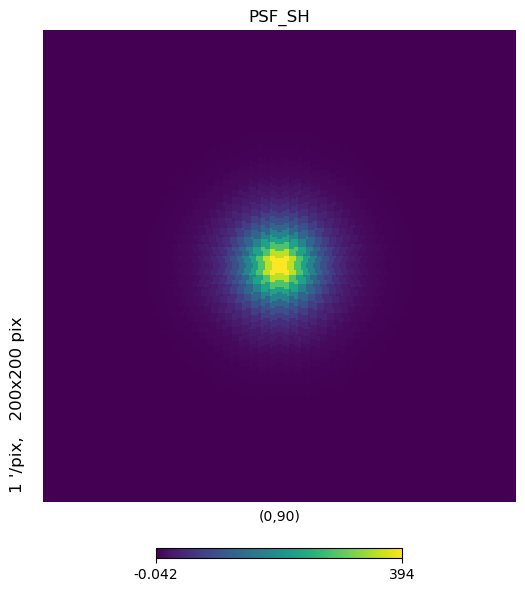

In [18]:
hp.gnomview(np.sum(PSF2, axis=0), rot=[0, 90], xsize=200, reso=1)
plt.title("PSF_SH")


In [19]:
response = np.zeros([len(Energybin) - 1, len(priEnergybin) - 1])
for i in range(len(priEnergybin) - 1):
    response[:, i], _ = np.histogram(
        MCdata["energy"][
            (MCdata["prie"] > priEnergybin[i]) & (MCdata["prie"] < priEnergybin[i + 1])
        ],
        bins=Energybin,
    )


In [20]:
prie_hist, _ = np.histogram(MCdata["prie"], bins=priEnergybin)
energy_hist, _ = np.histogram(MCdata["energy"], bins=Energybin)
response = response / prie_hist


In [21]:
prie_hist


array([  14,  151,  754, 2407, 4782, 6085, 5765, 4537, 3019, 1888, 1117,
        720,  421,  248,  144,   94,   53])

In [22]:
response[np.isnan(response)] = 0


In [23]:
pridata = uproot.open(
    "/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/priall.root"
)
pridata = pridata["tpri"].arrays(pridata["tpri"].keys(), library="np")


In [24]:
priorg_hist, _ = np.histogram(pridata["e"] / 1000, bins=priEnergybin)
eta = prie_hist / priorg_hist


In [25]:
prie_hist

array([  14,  151,  754, 2407, 4782, 6085, 5765, 4537, 3019, 1888, 1117,
        720,  421,  248,  144,   94,   53])

In [26]:
priorg_hist

array([1897760, 1093470,  629180,  364260,  211930,  119940,   69300,
         40580,   22670,   12760,    7530,    4490,    2640,    1440,
           850,     530,     310])

In [27]:
eta

array([7.37711829e-06, 1.38092495e-04, 1.19838520e-03, 6.60791742e-03,
       2.25640542e-02, 5.07337002e-02, 8.31890332e-02, 1.11803844e-01,
       1.33171592e-01, 1.47962382e-01, 1.48339973e-01, 1.60356347e-01,
       1.59469697e-01, 1.72222222e-01, 1.69411765e-01, 1.77358491e-01,
       1.70967742e-01])

In [28]:
del MCdata
del pridata


In [29]:
class sourcemodel:
    def __init__(
        self,
        response,
        eta,
        T=719.15 * time_rate * 24 * 60 * 60,
        area=30000 * 30000 * 3.1415926,
        spectrumfunction="Cutoff_powerlaw",
        spacefunction="disksource",
        **args
    ) -> None:
        if spectrumfunction == "Cutoff_powerlaw":
            self.spectrumfunction = self.Cutoff_powerlaw
        if spectrumfunction == "powerlaw":
            self.spectrumfunction = self.powerlaw
        if spacefunction == "disksource":
            self.spacefunction = self.disksource
        self.response = response
        self.eta = eta
        self.T = T
        self.area = area
        self.energybin = priEnergybin
        self.energybincenter = 10 ** (
            (np.log10(self.energybin[:-1]) + np.log10(self.energybin[1:])) / 2
        )
        self.obenergybin = Energybin

        if "K" in args:
            self.K = args["K"]
        if "index" in args:
            self.index = args["index"]
        if "E_cut" in args:
            self.E_cut = args["E_cut"]
        else:
            self.E_cut = None
        if "Ra" in args:
            self.Ra = args["Ra"]
        if "Dec" in args:
            self.Dec = args["Dec"]
        if "sourcetype" in args:
            self.sourcetype = args["sourcetype"]
        if "radius" in args:
            self.radius = args["radius"]
        else:
            self.radius= None
        if "radius2" in args:
            self.radius2 = args["radius2"]
        else:
            self.radius2= None

    def Cutoff_powerlaw(self, x, K, index, E_cut):
        return 10**K * (x / 1) ** index * np.exp(-x / E_cut)
    
    def powerlaw(self, x, K, index, E_cut):
        return 10**K * (x / 1) ** index

    def disksource(self, Ra, Dec, sourcetype="point", radius=None, radius2=None):
        if sourcetype == "point":
            pix = hp.ang2pix(NSIDE, Ra, Dec, lonlat=True)
            return pix
        elif sourcetype == "extend":
            pix = hp.query_disc(
                NSIDE,
                hp.ang2vec(Ra, Dec, lonlat=True),
                radius=np.radians(radius),
            )
            return pix
        elif sourcetype == "ring":
            pix1 = hp.query_disc(
                NSIDE,
                hp.ang2vec(Ra, Dec, lonlat=True),
                radius=np.radians(radius),
            )
            pix2 = hp.query_disc(
                NSIDE,
                hp.ang2vec(Ra, Dec, lonlat=True),
                radius=np.radians(radius2),
            )
            pix = list(set(pix1) - set(pix2))
            return pix

    def getmap_beforePSF(self):
        hp_map = np.zeros([len(self.obenergybin) - 1, NPIX])
        org_number = np.zeros(len(self.energybincenter))
        pixneed = self.spacefunction(self.Ra, self.Dec, self.sourcetype, self.radius,self.radius2)
        for i in range(len(self.energybincenter)):
            org_number[i] = (
                self.spectrumfunction(
                    self.energybincenter[i], self.K, self.index, self.E_cut
                )
                * self.T
                * self.area
                * (self.energybin[i + 1] - self.energybin[i])
            )
        ob_number = np.matmul(self.response, self.eta * org_number)
        # print(ob_number)
        for i in range(len(self.obenergybin) - 1):
            hp_map[i][pixneed] = 1
            if np.sum(hp_map[i]) != 0:
                hp_map[i] = hp_map[i] / np.sum(hp_map[i]) * ob_number[i]
        return hp_map

    def getmap(self, PSFl):
        hp_map = self.getmap_beforePSF()
        # print(hp_map.shape)
        pixneed = hp.query_disc(
            NSIDE, hp.ang2vec(self.Ra, self.Dec, lonlat=True), np.deg2rad(5)
        )
        for i in range(len(self.obenergybin) - 1):
            # print(i)
            eventnumber = np.sum(hp_map[i])
            if eventnumber != 0:
                hp_map[i] = hp.smoothing(hp_map[i], beam_window=PSFl[i])
                hp_map[i][hp_map[i] < 0] = 0
                hp_map[i][pixneed] = (
                    hp_map[i][pixneed] / np.sum(hp_map[i][pixneed]) * eventnumber
                )
        return hp_map


In [30]:
J1857 = sourcemodel(
    response,
    eta,
    Ra=284.34,
    Dec=2.76,
    sourcetype="extend",
    radius=0.26,
    K=np.log10(7.9e-12),
    index=-2.15,
    E_cut=11,
)
J1858 = sourcemodel(
    response,
    eta,
    Ra=284.57,
    Dec=2.06,
    sourcetype="point",
    spectrumfunction="powerlaw",
    K=np.log10(5e-13),
    index=-2.11,
)


In [31]:
J1857_map = J1857.getmap(PSFl)
J1858_map = J1858.getmap(PSFl)


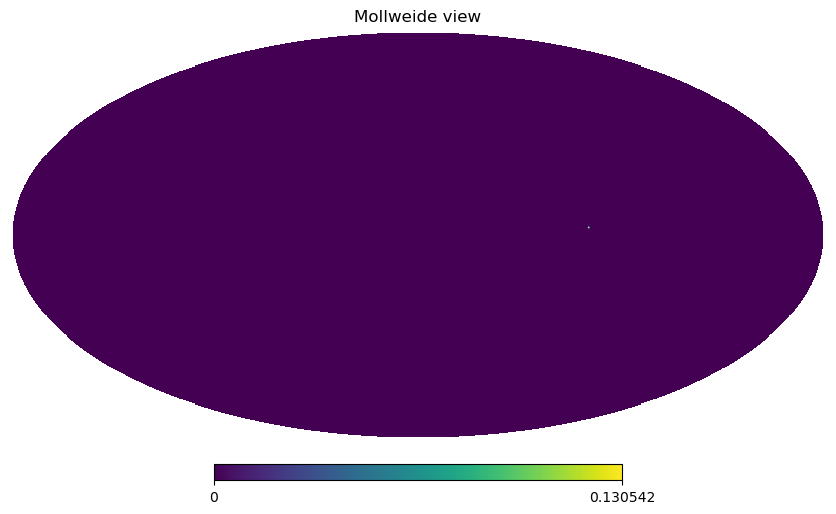

In [104]:
hp.mollview(np.sum(J1857_map, axis=0))
# hp.mollview(np.sum(J1858_map, axis=0))


In [105]:
np.sum(J1858_map+J1857_map)


55.807587135138775

In [32]:
# Background = np.zeros([len(Energybin) - 1, NPIX])
# for i in range(40):
#     Background +=np.load(f"/home2/hky/github/Gamma_Energy/find_source/data/isgammacut_0.8/splitmjd/Background{i}.npy")
# np.save("/home2/hky/github/Gamma_Energy/find_source/data/isgammacut_0.8/splitmjd/Background.npy",Background)
Background = np.load(
    "/home2/hky/github/Gamma_Energy/find_source/data/isgammacut_0.8/splitmjd/Background.npy"
)


In [33]:
# DataPath = (
#     "/home2/hky/github/Gamma_Energy/Exptdata/ALLsky_23_05_17_isgammacuted_E_Ra_Dec_new"
# )
# Exptdata = dict()
# for root, dirs, files in os.walk(DataPath):
#     for name in files:
#         Exptdata_tmp = np.load(os.path.join(root, name))
#         Exptcut = np.where(Exptdata_tmp["isgamma"] > 0.6)
#         for key in Exptdata_tmp:
#             if key not in Exptdata.keys():
#                 Exptdata[key] = list()
#             Exptdata[key].append(Exptdata_tmp[key][Exptcut])
# for key in Exptdata.keys():
#     Exptdata[key] = np.concatenate(Exptdata[key])


In [34]:
# On  = np.zeros([len(Energybin) - 1, NPIX])
# for i in range(len(Energybin)-1):
#     need = np.where((Exptdata["energy"]>Energybin[i])&(Exptdata["energy"]<Energybin[i+1]))
#     np.add.at(On[i],hp.ang2pix(NSIDE,Exptdata["Ra"][need],Exptdata["Dec"][need],lonlat=True),1)
# np.save("/home2/hky/github/Gamma_Energy/J1857/direct_int_ag_background/On.npy",On)
# del Exptdata
On = np.load("/home2/hky/github/Gamma_Energy/find_source/data/isgammacut_0.8/All.npy")


In [35]:
Background = Background[3:-10, :]
On = On[3:-10]


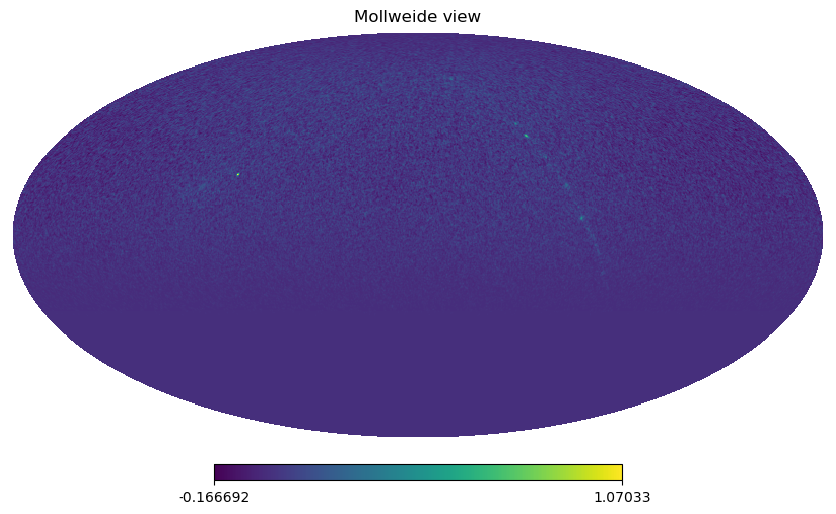

In [110]:
hp.mollview(hp.smoothing(np.sum(On - Background, axis=0), fwhm=np.deg2rad(0.5)))


In [111]:
np.sum((On-Background)[:,hp.query_disc(NSIDE,hp.ang2vec(284.5,2.5,lonlat=True),np.radians(0.5))])

28.79282373289327

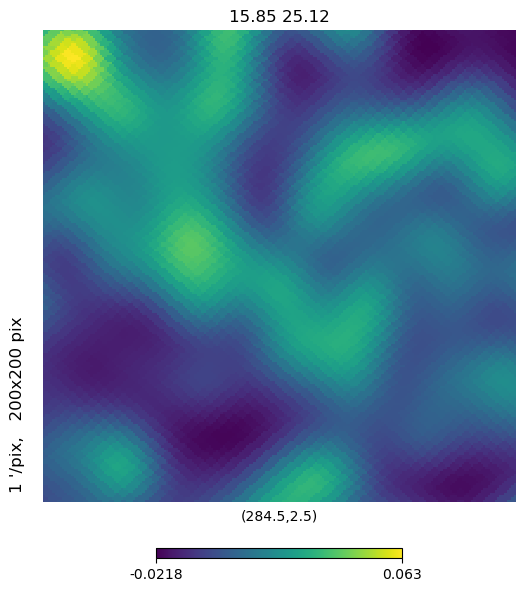

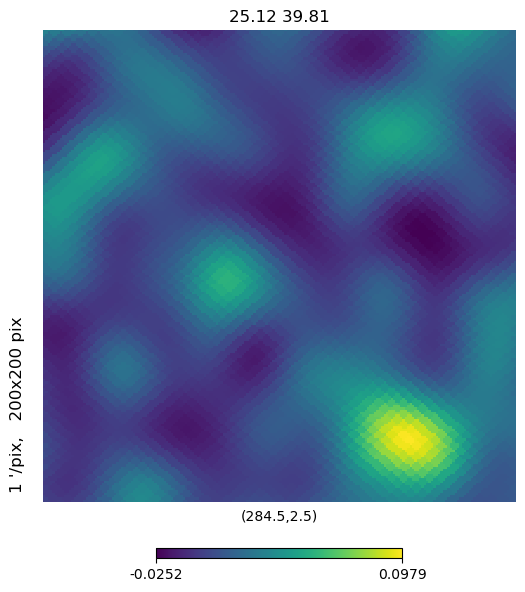

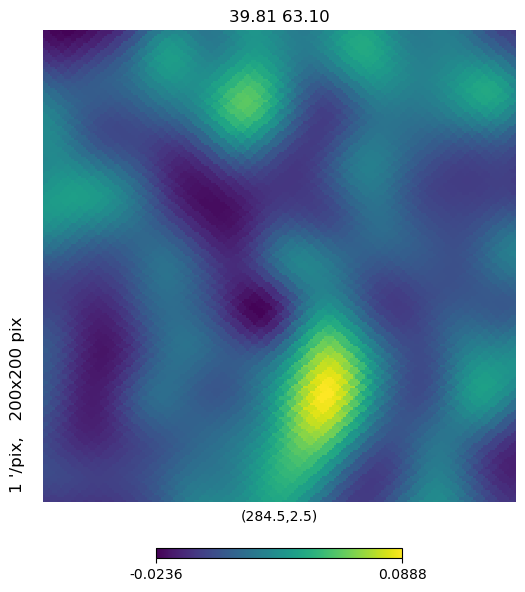

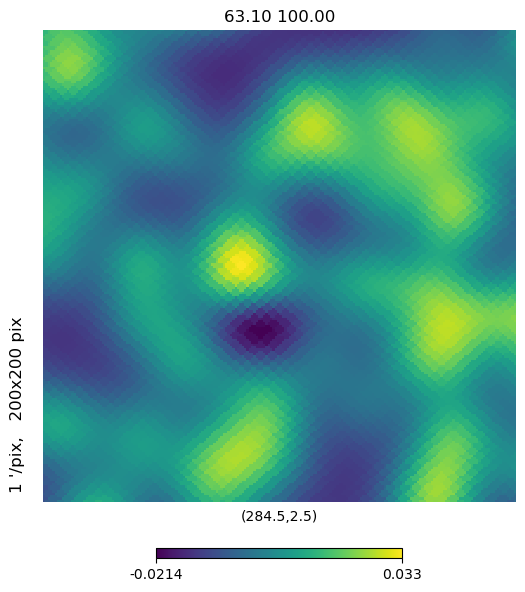

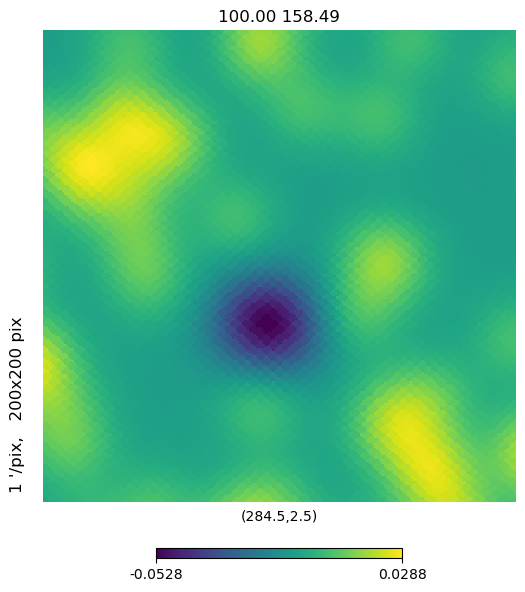

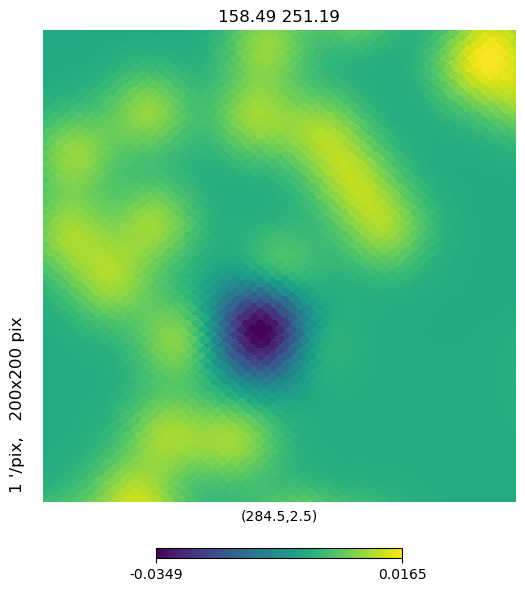

In [112]:
for i in range(On.shape[0]):
    hp.gnomview(
        hp.smoothing((On[i] - Background[i]-J1857_map[i]-J1858_map[i]), fwhm=np.deg2rad(0.5)),
        rot=[284.5, 2.5],
        xsize=200,
        reso=1,
    )
    plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
    plt.show()

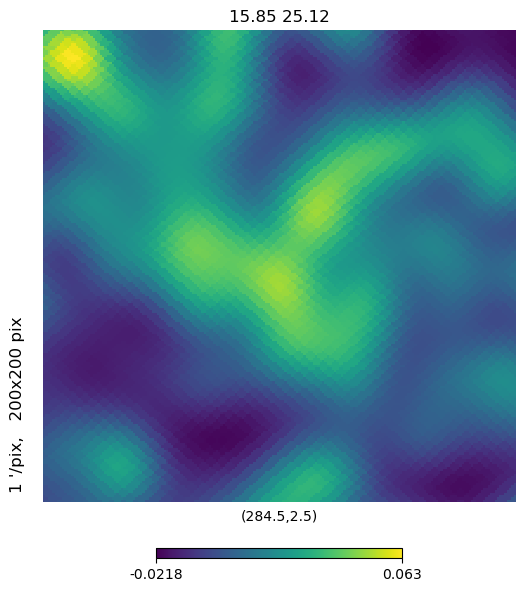

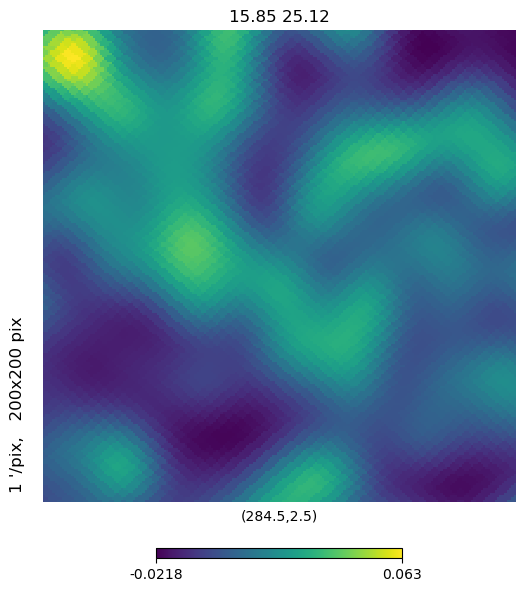

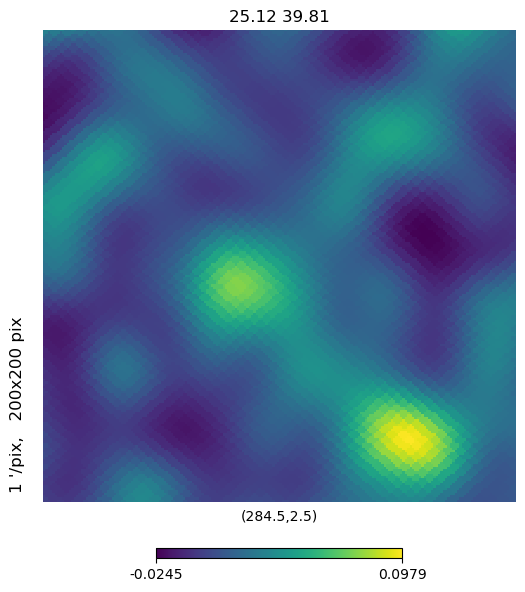

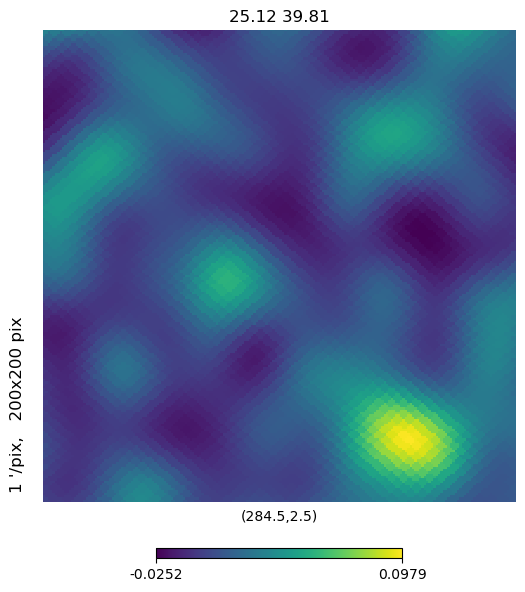

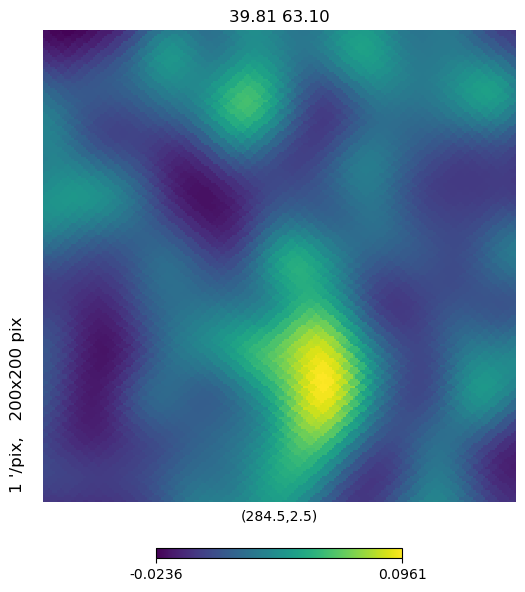

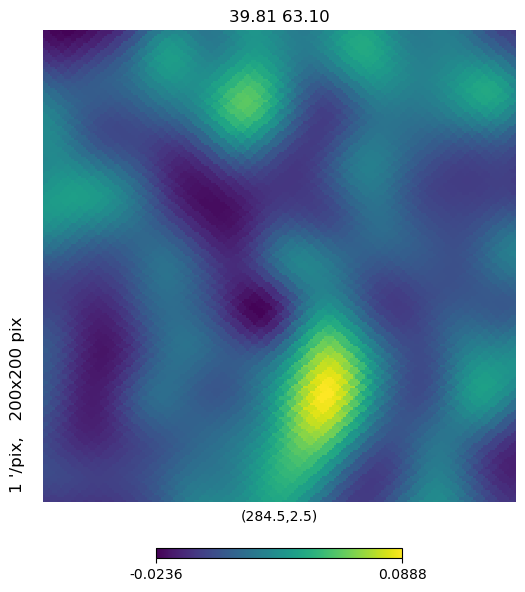

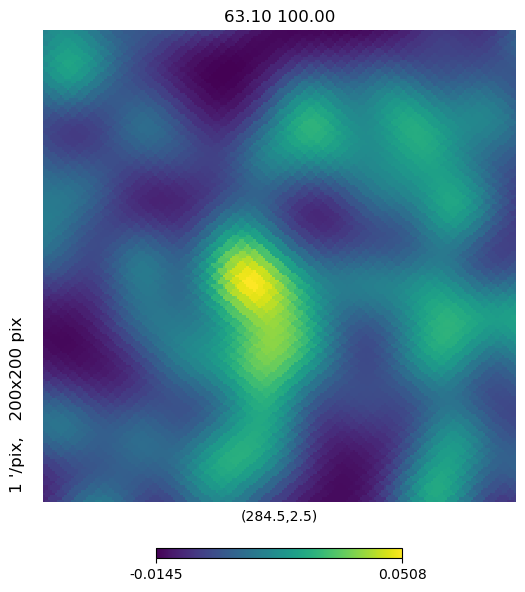

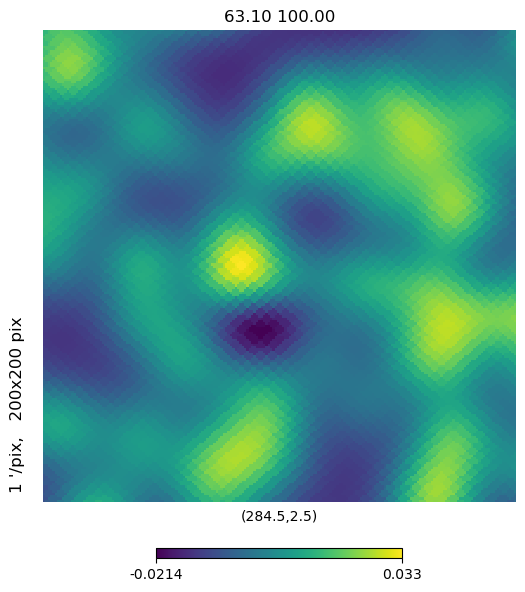

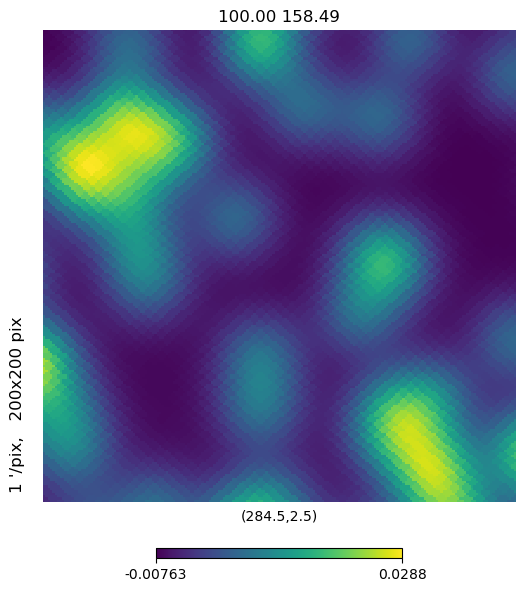

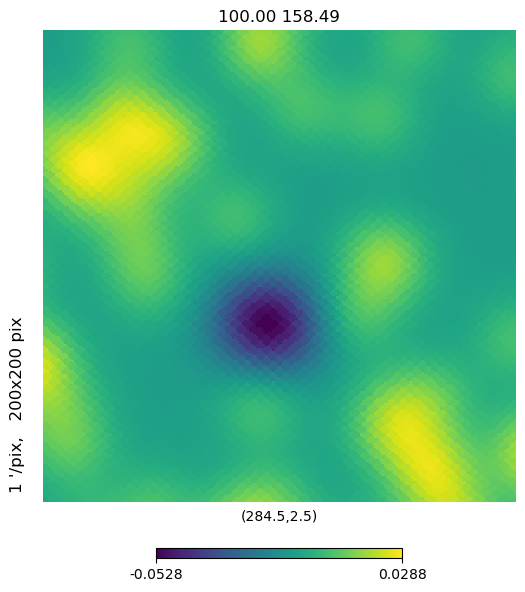

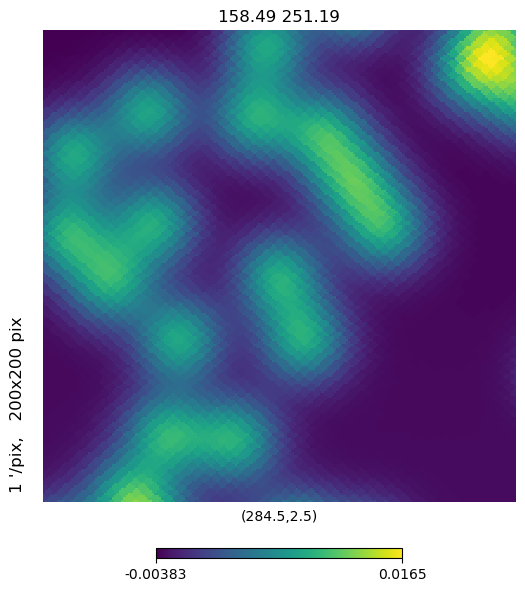

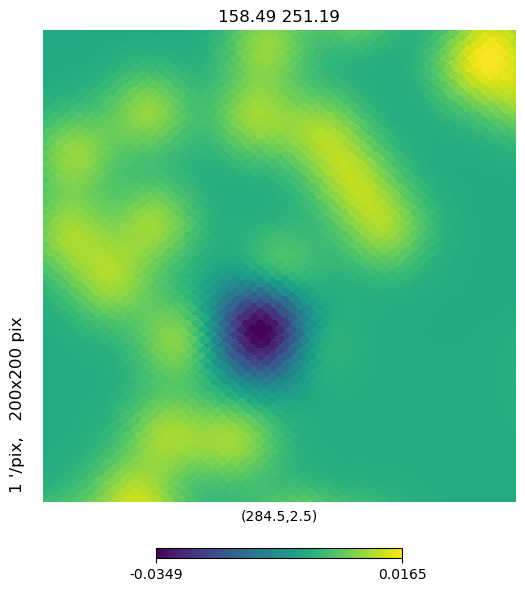

In [113]:
for i in range(On.shape[0]):
    hp.gnomview(
        hp.smoothing((On[i] - Background[i]), fwhm=np.deg2rad(0.5)),
        rot=[284.5, 2.5],
        xsize=200,
        reso=1,
    )
    plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
    plt.show()
    hp.gnomview(
        hp.smoothing((On[i] - Background[i]-J1857_map[i]-J1858_map[i]), fwhm=np.deg2rad(0.5)),
        rot=[284.5, 2.5],
        xsize=200,
        reso=1,
    )
    plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
    plt.show()

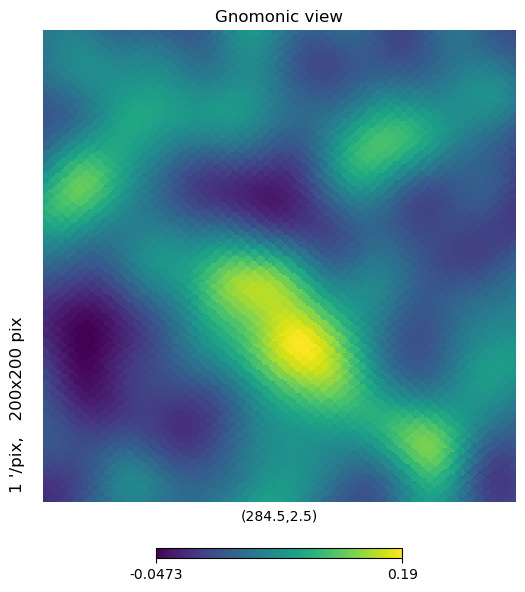

In [114]:
# for i in range(On.shape[0]):
hp.gnomview(
    hp.smoothing(np.sum((On - Background-(J1857_map)),axis=0), fwhm=np.deg2rad(0.5)),
    rot=[284.5, 2.5],
    xsize=200,
    reso=1,
)
# plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
plt.show()

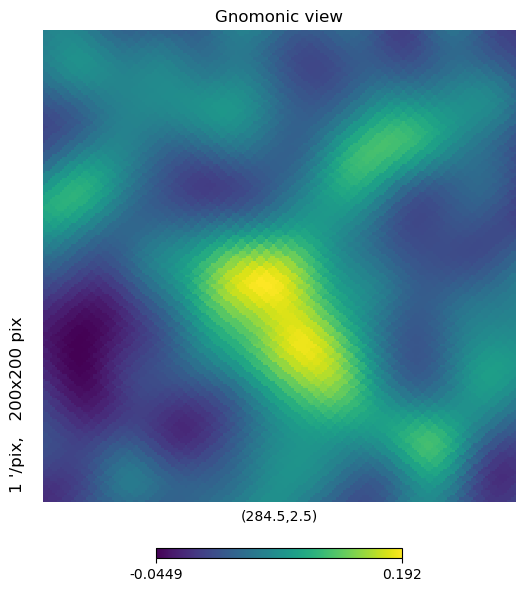

In [63]:
# for i in range(On.shape[0]):
hp.gnomview(
    hp.smoothing(np.sum((On - Background),axis=0), fwhm=np.deg2rad(0.5)),
    rot=[284.5, 2.5],
    xsize=200,
    reso=1,
)
# plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
plt.show()

In [36]:
np.sum((On - Background-J1857_map-J1858_map)[:,hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(0.5))],axis=1)

array([ 4.96355546, -2.51770676,  0.92326349,  1.29495033])

In [37]:
np.sum((On - Background-J1857_map-J1858_map)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1)

array([4.07881768, 3.89284205, 4.38460229, 2.02090333])

In [38]:
np.sum((On - Background)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1)

array([ 7.70039074, 11.12803541, 13.86017222, 10.44389294])

In [39]:

for angel in np.linspace(0.1,1,10):
    print(angel,np.sum((On-Background)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(angel))],axis=1)/np.sqrt(np.sum((Background)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(angel))],axis=1)))

0.1 [ 1.39020941 -0.57537554 -0.51612594 -0.36383361]
0.2 [0.78555049 0.5048463  0.82010818 3.25637467]
0.30000000000000004 [2.62845095 2.067973   3.93146474 4.10208625]
0.4 [2.43079988 3.03443321 2.97253037 3.76158177]
0.5 [2.85011876 3.7360149  5.18710164 5.53828113]
0.6 [2.59595729 3.67266864 5.80819532 4.34342826]
0.7000000000000001 [2.81640963 3.73191599 5.60374969 3.79195464]
0.8 [3.29494906 2.98340527 5.76561792 3.93426333]
0.9 [3.35456693 3.40020241 5.58131645 3.67611781]
1.0 [3.07843631 3.07774107 6.03815672 3.8993797 ]


In [40]:
from pyunfold import iterative_unfold

data = np.sum((On - Background-J1858_map)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1)
data_err = np.sqrt(np.sum((On)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1))

In [41]:
np.sum((On - Background)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1)

array([ 7.70039074, 11.12803541, 13.86017222, 10.44389294])

In [75]:
(np.sum(
    J1858_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.57, 2.06, lonlat=True), np.deg2rad(0.5))
    ],
    axis=1,
)/np.sum(
    J1858_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.57, 2.06, lonlat=True), np.deg2rad(10))
    ],
    axis=1,
)
)

array([0.92369389, 0.96380122, 0.98317856, 0.99908845])

In [58]:
priEnergybin

array([3.98107171e+00, 6.30957344e+00, 1.00000000e+01, 1.58489319e+01,
       2.51188643e+01, 3.98107171e+01, 6.30957344e+01, 1.00000000e+02,
       1.58489319e+02, 2.51188643e+02, 3.98107171e+02, 6.30957344e+02,
       1.00000000e+03, 1.58489319e+03, 2.51188643e+03, 3.98107171e+03,
       6.30957344e+03, 1.00000000e+04])

In [82]:
np.sum((On - Background-J1857_map)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1)/eta[4:8]/(719.15 * time_rate * 24 * 60 * 60*30000 * 30000 * 3.1415926)*np.logspace(1.3,1.9,4)**2/(Energybin[1:]-Energybin[:-1])/(np.sum(
    J1858_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.57, 2.06, lonlat=True), np.deg2rad(0.5))
    ],
    axis=1,
)/np.sum(
    J1858_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.57, 2.06, lonlat=True), np.deg2rad(10))
    ],
    axis=1,
)
)

array([2.53495414e-13, 2.61106081e-13, 3.24907611e-13, 2.89480015e-13])

In [68]:
np.sqrt(np.sum((On)[:,hp.query_disc(NSIDE, hp.ang2vec(284.57,2.06, lonlat=True), np.deg2rad(0.5))],axis=1))/eta[4:8]/(719.15 * time_rate * 24 * 60 * 60*30000 * 30000 * 3.1415926)*np.logspace(1.3,1.9,4)**2/(Energybin[1:]-Energybin[:-1])

array([1.34123244e-13, 1.09167663e-13, 1.08123258e-13, 1.04107696e-13])

In [81]:
np.sum((On - Background-J1858_map)[:,hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(0.5))],axis=1)/eta[4:8]/(719.15 * time_rate * 24 * 60 * 60*30000 * 30000 * 3.1415926)*np.logspace(1.3,1.9,4)**2/(Energybin[1:]-Energybin[:-1])/(np.sum(
    J1857_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(0.5))
    ],
    axis=1,
)/np.sum(
    J1857_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(10))
    ],
    axis=1,
)
)

array([4.33008600e-13, 1.04104360e-13, 9.25435918e-14, 5.15715534e-14])

In [80]:
np.sqrt(np.sum((On)[:,hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(0.5))],axis=1))/eta[4:8]/(719.15 * time_rate * 24 * 60 * 60*30000 * 30000 * 3.1415926)*np.logspace(1.3,1.9,4)**2/(Energybin[1:]-Energybin[:-1])/(np.sum(
    J1857_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(0.5))
    ],
    axis=1,
)/np.sum(
    J1857_map[
        :, hp.query_disc(NSIDE, hp.ang2vec(284.34,2.76, lonlat=True), np.deg2rad(10))
    ],
    axis=1,
)
)

array([1.73029884e-13, 9.72985068e-14, 8.55169324e-14, 6.91902619e-14])

In [42]:
response_err = np.zeros_like(response)
eta_err = np.zeros_like(eta)

In [43]:
unfolded_result = iterative_unfold(data=data,
                                   data_err=data_err,
                                   response=response,
                                   response_err=response_err,
                                   efficiencies=eta,
                                   efficiencies_err=eta_err)

array([1.28835819e+06, 2.94719510e+04, 5.97686892e+02, 4.08698465e+01,
       1.62591327e+01, 1.62406289e+01, 8.76039017e+00, 2.27573943e-01,
       2.33633114e-04, 4.12786878e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [47]:
unfolded_result["stat_err"]

array([7.95051306e+05, 3.80340304e+04, 3.28579277e+03, 1.04393411e+03,
       2.22998762e+02, 3.54011446e+01, 2.18488155e+01, 1.03729343e+00,
       1.73092931e-01, 2.56101191e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [53]:
priEnergybin.shape

(18,)

In [56]:
        
unfolded_result['stat_err']/(priEnergybin[1:]-priEnergybin[:-1])/(719.15 * time_rate * 24 * 60 * 60*30000 * 30000 * 3.1415926)*np.logspace(0.7,3.9,17)**2

array([1.56052492e-10, 1.18317205e-11, 1.62000264e-12, 8.15734150e-13,
       2.76170957e-13, 6.94852873e-14, 6.79678374e-14, 5.11419381e-15,
       1.35255485e-15, 3.17166385e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [ ]:
unfolded_result['unfolded']/

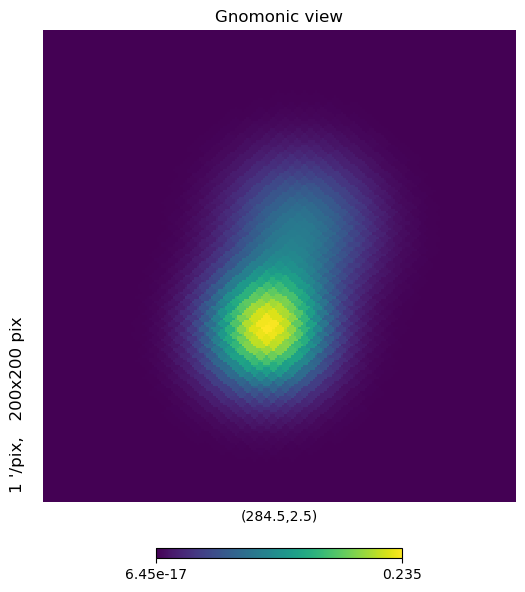

In [54]:
# for i in range(On.shape[0]):
hp.gnomview(
    hp.smoothing(np.sum(((J1858_map+J1857_map)),axis=0), fwhm=np.deg2rad(0.5)),
    rot=[284.5, 2.5],
    xsize=200,
    reso=1,
)
# plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
plt.show()

In [ ]:
for i in range(On.shape[0]):
    hp.gnomview(
        hp.smoothing((On[i] - Background[i]), fwhm=np.deg2rad(0.5)),
        rot=[284.5, 2.5],
        xsize=200,
        reso=1,
    )
    plt.title(f"{Energybin[i]:.2f} {Energybin[i+1]:.2f}")
    plt.show()

In [52]:
TeVdata = pd.read_table("/home2/hky/github/Gamma_Energy/AllSky_withCR/TeVcat.log")
Ra_TeVcat = TeVdata["Ra"].to_numpy()
Dec_TeVcat = TeVdata["Dec"].to_numpy()
for i in range(len(Ra_TeVcat)):
    Ra_TeVcat_tmp = Ra_TeVcat[i].split()
    Dec_TeVcat_tmp = Dec_TeVcat[i].split()
    Ra_TeVcat[i] = (
        float(Ra_TeVcat_tmp[0]) / 24
        + float(Ra_TeVcat_tmp[1]) / 24 / 60
        + float(Ra_TeVcat_tmp[2]) / 24 / 60 / 60
    ) * 360
    Dec_TeVcat[i] = float(Dec_TeVcat_tmp[0])
    delta_Dec_TeVcat = (
        float(Dec_TeVcat_tmp[1]) / 60 + float(Dec_TeVcat_tmp[2]) / 60 / 60
    )
    Dec_TeVcat[i] += (-1) ** (Dec_TeVcat[i] < 0) * delta_Dec_TeVcat

Ra_TeVcat = Ra_TeVcat.astype(np.float32)
Dec_TeVcat = Dec_TeVcat.astype(np.float32)
TeVname = TeVdata["Name"]
TeVtype = TeVdata["Type"]


In [53]:
# hp_map = hp.smoothing(np.sum(On-Background,axis=0),fwhm=np.radians(0.3))


def drawgnomview(hp_map, Ra, Dec, reso=1, drawdeg=2):
    binsnumber = int(drawdeg * 60 / reso * 2)
    hp_map_tmp = hp.gnomview(
        hp_map,
        rot=[Ra, Dec],
        xsize=drawdeg * 60 / reso * 2,
        reso=reso,
        return_projected_map=True,
        no_plot=True,
    )
    hp_map_tmp_inv = np.zeros_like(hp_map_tmp)
    for i in range(hp_map_tmp.shape[0]):
        hp_map_tmp_inv[:, i] = hp_map_tmp[:, hp_map_tmp.shape[0] - 1 - i]
    fig, ax = plt.subplots(figsize=(8, 5))
    c = ax.pcolormesh(
        np.linspace(
            Ra - drawdeg / np.cos(np.deg2rad(Dec)),
            Ra + drawdeg / np.cos(np.deg2rad(Dec)),
            binsnumber,
        ),
        np.linspace(
            Dec - drawdeg,
            Dec + drawdeg,
            binsnumber,
        ),
        hp_map_tmp_inv,
        cmap="plasma",
        # vmin=3,
    )
    Ra_min = Ra - drawdeg / np.cos(np.deg2rad(Dec))
    Ra_max = Ra + drawdeg / np.cos(np.deg2rad(Dec))
    Dec_min = Dec - drawdeg
    Dec_max = Dec + drawdeg
    flag = 0
    for Tname, Ttype, Ra2, Dec2 in zip(TeVname, TeVtype, Ra_TeVcat, Dec_TeVcat):
        if Ra_max > Ra2 > Ra_min and Dec_max > Dec2 > Dec_min:
            flag = 1
            ax.scatter(
                Ra2,
                Dec2,
                # c="r",
                # marker="x",
                label=f"{Tname}({Ttype})",
            )
    fig.colorbar(c, orientation="vertical")
    ax.set_xlim(
        Ra - drawdeg / np.cos(np.deg2rad(Dec)),
        Ra + drawdeg / np.cos(np.deg2rad(Dec)),
    )
    ax.set_ylim(Dec - drawdeg, Dec + drawdeg)
    ax.invert_xaxis()
    plt.legend()
    plt.show()
    return hp_map_tmp_inv


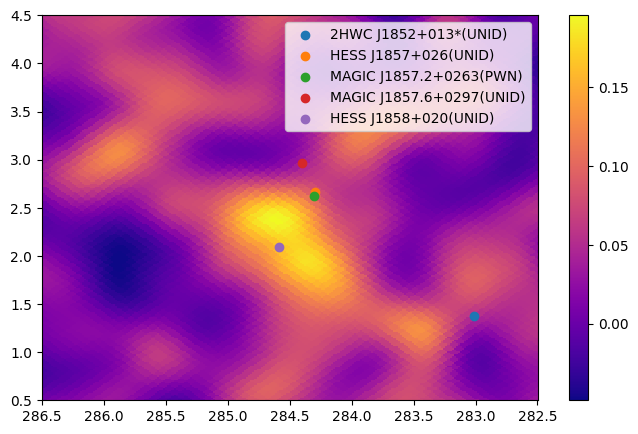

In [12]:
hp_map_tmp_inv = drawgnomview(hp.smoothing(np.sum(On - Background, axis=0),np.deg2rad(0.5)), 284.5, 2.5)


In [42]:
On_sum = np.sum(On, axis=0)
Background_sum = np.sum(Background, axis=0)


def getsigma(pix):
    PSF_All = np.sum(PSF, axis=0)
    PSF_All = hp.alm2map(hp.map2alm(PSF_All, mmax=0), NSIDE, lmax=3 * NSIDE - 1, mmax=0)
    PSF_All = PSF_All / np.sum(PSF_All)
    pix_need = hp.query_disc(NSIDE, hp.pix2vec(NSIDE, pix), np.deg2rad(3))
    Ra, Dec = hp.pix2ang(NSIDE, pix, lonlat=True)
    PSF_All_rotator = hp.Rotator(rot=[0, 90], deg=True)
    PSF_All_rotator2 = hp.Rotator(rot=[Ra, Dec], deg=True, inv=True)
    PSF_All = PSF_All_rotator2.rotate_map_pixel(
        PSF_All_rotator.rotate_map_pixel(PSF_All)
    )

    prob0 = poisson.pmf(On_sum[pix_need], Background_sum[pix_need])
    lnprob0 = np.sum(np.log(prob0))

    # print(lnprob0)
    def getprobA(A):
        # print(A)
        prob = poisson.pmf(
            On_sum[pix_need], Background_sum[pix_need] + A * PSF_All[pix_need]
        )
        return -np.sum(np.log(prob))

    A = 0
    res = minimize(getprobA, A, bounds=[(-1000, 1000)])
    # print(res)
    sig = np.sqrt(2 * (-res.fun - lnprob0))
    if res.x[0] < 0:
        sig = -sig

    return sig


In [43]:
sigma = np.zeros(NPIX)
for i in tqdm(
    np.arange(NPIX)[
        hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(1))
    ]
):
    sigma[i] = getsigma(i)


  0%|          | 0/957 [00:00<?, ?it/s]

KeyboardInterrupt: 

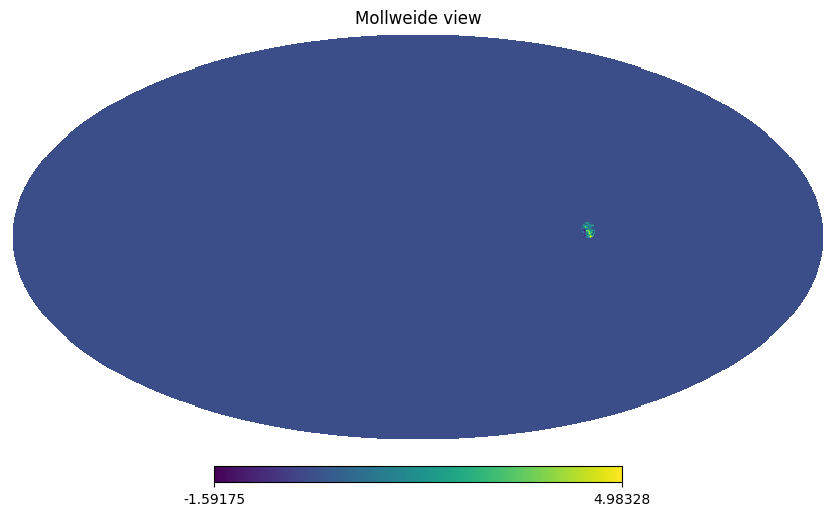

In [ ]:
hp.mollview(sigma)


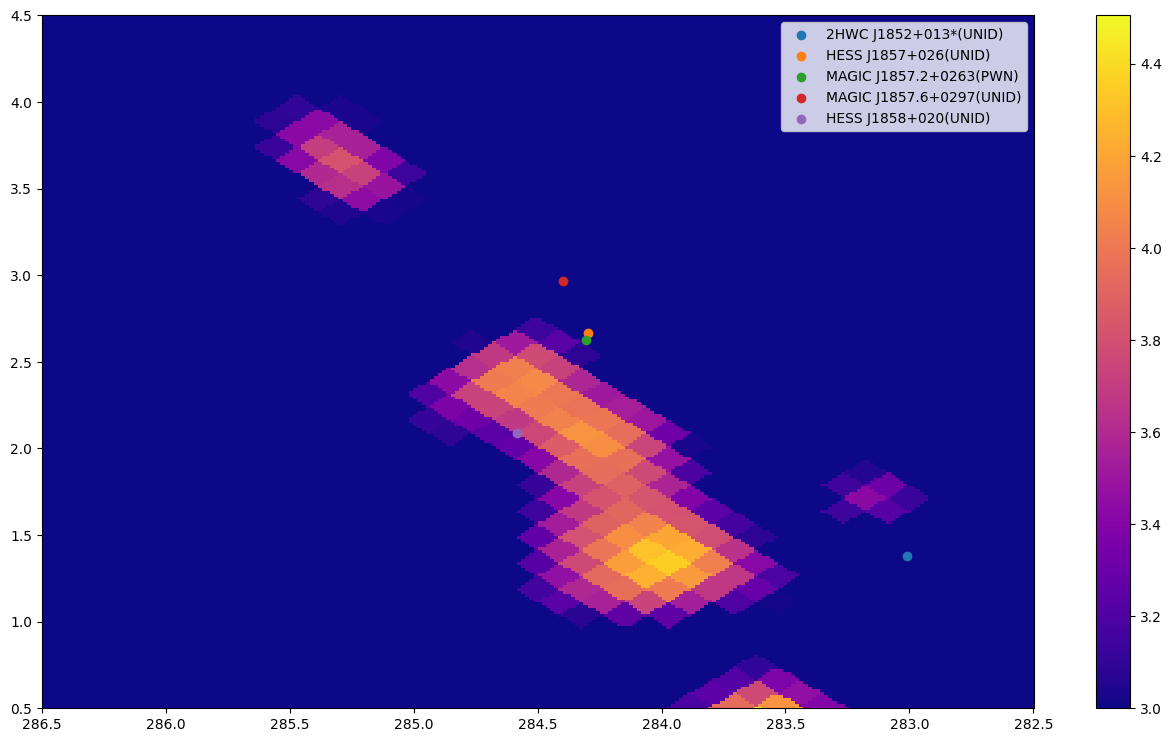

In [ ]:
drawgnomview(sigma, 284.5, 2.5, drawdeg=2)


In [69]:
def log_prob(par):
    J1857 = sourcemodel(
        response,
        eta,
        Ra=284.34,
        Dec=2.76,
        sourcetype="extend",
        radius=0.26,
        K=par[0],
        index=-2.15,
        E_cut=par[1],
    )
    J1858 = sourcemodel(
        response,
        eta,
        Ra=284.57,
        Dec=2.06,
        sourcetype="point",
        # radius=0.2,
        # radius2=0.3,
        spectrumfunction="powerlaw",
        K=par[2],
        index=-2.11,
        # E_cut=par[3],
    )
    J1857_map = J1857.getmap(PSFl)
    J1858_map = J1858.getmap(PSFl)
    All_map = J1857_map + J1858_map
    pix_need = hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(3))
    All_map[All_map < 0] = 0
    pre = Background[:, pix_need] + All_map[:, pix_need]

    prob = poisson.pmf(On[:, pix_need], pre)
    # return prob
    if np.any(prob == 0):
        return -np.inf
    print(np.sum(np.log(prob)))
    return np.sum(np.log(prob))


def log_prob0():
    pix_need = hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(3))
    prob = poisson.pmf(On[:, pix_need], Background[:, pix_need])
    # return prob
    if np.any(prob == 0):
        return -np.inf
    return np.sum(np.log(prob))


def neg_log_prob(par):
    return -log_prob(par)


In [70]:
# J1857 = sourcemodel(response,eta,Ra=284.34,Dec=2.76,sourcetype="extend",radius=0.26,K=1.9e-15,index=-2.15,E_cut=1.5e1)
# J1858 = sourcemodel(response,eta,Ra=284.57,Dec=2.06,sourcetype="point",K=2.7e-16,index=-2.08,E_cut=0.9e2)
par0 = [-1.110e01, 1.100e01, -1.231e01]
bounds = [
    # (0.01, 0.5),
    (-15, -10),
    # (-3, -1.5),
    (0.1, 200),
    (-15, -10),
    # (-3, -1.5),
    # (0.1, 200),
]
logprob = log_prob(par0)
logprob0 = log_prob0()
print(logprob, logprob0, 2 * (logprob - logprob0))


-6439.269287108656
-6439.269287108656 -6454.117785796829 29.69699737634619


In [71]:
res = minimize(neg_log_prob, par0, bounds=bounds)

-6439.269287108656
-6439.269287111491
-6439.269287109007
-6439.269287238679
-6449.375214482443
-6449.375214421825
-6449.375214477663
-6449.375214480191
-6441.120655067614
-6441.120655039478
-6441.12065506545
-6441.120654974957
-6438.318573683616
-6438.318573675011
-6438.318573683038
-6438.318573677523
-6438.307998473952
-6438.3079984694305
-6438.3079984737
-6438.307998472513
-6438.305078370534
-6438.305078370337
-6438.305078370628
-6438.3050783712
-6438.305030769847
-6438.3050307698095
-6438.305030769951
-6438.305030769971
-6438.3050261609205
-6438.305026160922
-6438.305026161029
-6438.305026160897


In [72]:
res


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6438.3050261609205
        x: [-1.109e+01  1.100e+01 -1.248e+01]
      nit: 5
      jac: [ 1.819e-04  1.082e-02 -2.365e-03]
     nfev: 32
     njev: 8
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [77]:
10**res.x[2]

3.3425467971332636e-13

In [74]:
np.sqrt(2*(-6438.3050261609205+6454.117785796829))

5.623657108307396

In [66]:
par = res.x

In [44]:
10**res.x[0]

3.596879368366752e-11

In [72]:
def log_prob(par):
    J1857 = sourcemodel(
        response,
        eta,
        Ra=284.34,
        Dec=2.76,
        sourcetype="extend",
        radius=0.26,
        K=par[0],
        index=-2.15,
        E_cut=par[1],
    )
    J1858 = sourcemodel(
        response,
        eta,
        Ra=284.57,
        Dec=2.06,
        sourcetype="ring",
        radius=0.2,
        radius2=0.3,
        K=par[2],
        index=-2.09,
        E_cut=par[3],
    )
    J1857_map = J1857.getmap(PSFl)
    # J1858_map = J1858.getmap(PSFl)
    All_map = J1857_map
    pix_need = hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(3))
    All_map[All_map < 0] = 0
    pre = Background[:, pix_need] + All_map[:, pix_need]

    prob = poisson.pmf(On[:, pix_need], pre)
    # return prob
    if np.any(prob == 0):
        return -np.inf
    print(np.sum(np.log(prob)))
    return np.sum(np.log(prob))


def log_prob0():
    pix_need = hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(3))
    prob = poisson.pmf(On[:, pix_need], Background[:, pix_need])
    # return prob
    if np.any(prob == 0):
        return -np.inf
    return np.sum(np.log(prob))


def neg_log_prob(par):
    return -log_prob(par)


In [73]:
log_prob(par)

-6007.949144898758


-6007.949144898758

In [40]:
2*(-5962.896947870324+6012.010586814981)

98.22727788931479

In [55]:
10 ** (-1.591e01)


1.2302687708123811e-16

In [56]:
10**-1.673e01


1.8620871366628655e-17